In [28]:
import pandas as pd
import tensorflow as tf
import numpy as np
import PIL
import os
import matplotlib.pyplot as plt
import joblib

from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from PIL import Image
from sklearn.metrics import classification_report,accuracy_score,precision_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils import shuffle

In [2]:
path = os.path.join('..','data', 'flowers')
dirs = os.listdir(path)
dirs

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [3]:
# функция для парсинга путей картинок, позволяет преобразовать все картинки
# в пути и запихнуть в один датафрейм
def get_photo_names(directory):
    name = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                name.append([os.path.join(root, file), root.split('\\')[-1]])
    return name

photo_names = get_photo_names(path)

df = pd.DataFrame(photo_names, columns=['photo_name', 'class'])
df

,photo_name,class
0,..\data\flowers\daisy\100080576_f52e8ee070_n.jpg,daisy
1,..\data\flowers\daisy\10140303196_b88d3d6cec.jpg,daisy
2,..\data\flowers\daisy\10172379554_b296050f82_n...,daisy
3,..\data\flowers\daisy\10172567486_2748826a8b.jpg,daisy
4,..\data\flowers\daisy\10172636503_21bededa75_n...,daisy
...,...,...
4312,..\data\flowers\tulip\9831362123_5aac525a99_n.jpg,tulip
4313,..\data\flowers\tulip\9870557734_88eb3b9e3b_n.jpg,tulip
4314,..\data\flowers\tulip\9947374414_fdf1d0861c_n.jpg,tulip
4315,..\data\flowers\tulip\9947385346_3a8cacea02_n.jpg,tulip


In [4]:
# хотим получать вектор признаков для каждого изображения, для
# этого загрузим уже обученную модель MobileNet
model = MobileNet(input_shape=(224,224,3), include_top=True)

model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [5]:
# с помощью слоя reshape_2, который является вектором из 1000 эл-тов
# хотим, чтобы слой предсказаний MobileNet принял в себя этот вектор, чтобы мы могли классифицировать
vector = model.get_layer("reshape_2").output
feature_extractor = tf.keras.Model(model.input, vector)

In [6]:
x = []           # массив всех картинок(векторов)

for image_path in df['photo_name']:
    img = image.load_img(image_path, target_size=(224, 224), color_mode='rgb')
    img_arr = image.img_to_array(img)
    img_arr_b = np.expand_dims(img_arr, axis=0)
    
    # обработка картинки 
    input_img = preprocess_input(img_arr_b)
    # извлечение фичей
    feature_vec = feature_extractor.predict(input_img)
    x.append(feature_vec.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [7]:
dirs = {
    'daisy': 1,
    'dandelion': 2,
    'rose': 3,
    'sunflower': 4,
    'tulip': 5
}


y = df['class'].to_list()
for flower in range(len(y)):
    y[flower] = dirs[y[flower]]


X = np.asarray(x, dtype=np.float32)
Y = np.asarray(y, dtype=np.float32)


for s in range(100):
    X, Y = shuffle(X, Y)
    
print("Размерность матрицы X", end='\n')
print(X.shape)
print("Размерность матрицы Y", end='\n')
print(Y.shape)

counts = np.unique(Y, return_counts=True)
print("Число различных картинок каждого класса:", end="\n")
print(counts)

Размерность матрицы X
(4317, 1000)
Размерность матрицы Y
(4317,)
Число различных картинок каждого класса:
(array([1., 2., 3., 4., 5.], dtype=float32), array([ 764, 1052,  784,  733,  984], dtype=int64))


In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Посмотрим на размерность данных
print("Размер обучающего набора:", x_train.shape, y_train.shape)
print("Размер тестового набора:", x_test.shape, y_test.shape)

Размер обучающего набора: (3453, 1000) (3453,)
Размер тестового набора: (864, 1000) (864,)


In [9]:
from sklearn.metrics import classification_report

model_ref = LogisticRegression(max_iter=1000)

model_knn = KNeighborsClassifier(n_neighbors=5)

model_svm_l = SVC(kernel='linear', max_iter=1000)  
model_svm_p = SVC(kernel='poly', max_iter=1000)
model_svm_r = SVC(kernel='rbf', max_iter=1000)

In [10]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix'):
    plt.matshow(df_confusion, cmap='winter') # imshow
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion))
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)
    
    for i in range(df_confusion.shape[0]):
        for j in range(df_confusion.shape[1]):
            plt.text(j, i, df_confusion[i, j], ha='center', va='center', color='black')

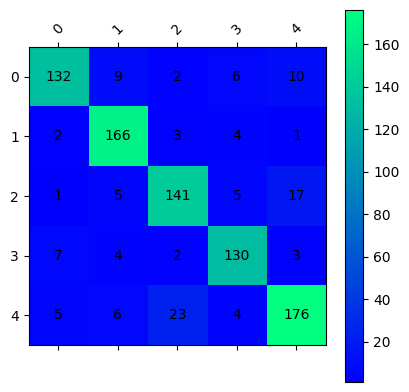

In [11]:
model_ref.fit(x_train, y_train)
y_pred = model_ref.predict(x_test)

df_confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(df_confusion)

In [12]:
recall = recall_score(y_test, y_pred, average='weighted')
recall

0.8622685185185185

In [13]:
print(classification_report(y_test, y_pred, target_names=dirs.keys()))

              precision    recall  f1-score   support

       daisy       0.90      0.83      0.86       159
   dandelion       0.87      0.94      0.91       176
        rose       0.82      0.83      0.83       169
   sunflower       0.87      0.89      0.88       146
       tulip       0.85      0.82      0.84       214

    accuracy                           0.86       864
   macro avg       0.86      0.86      0.86       864
weighted avg       0.86      0.86      0.86       864



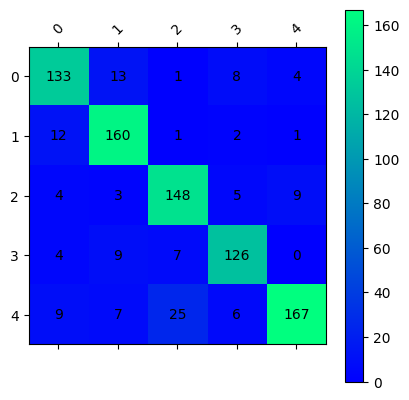

In [14]:
model_knn.fit(x_train, y_train)
y_pred = model_knn.predict(x_test)

df_confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(df_confusion)

In [15]:
rec_score = recall_score(y_test, y_pred, average='weighted')
rec_score

0.8495370370370371

In [16]:
print(classification_report(y_test, y_pred, target_names=dirs.keys()))

              precision    recall  f1-score   support

       daisy       0.82      0.84      0.83       159
   dandelion       0.83      0.91      0.87       176
        rose       0.81      0.88      0.84       169
   sunflower       0.86      0.86      0.86       146
       tulip       0.92      0.78      0.85       214

    accuracy                           0.85       864
   macro avg       0.85      0.85      0.85       864
weighted avg       0.85      0.85      0.85       864



D:\Project Fluids\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


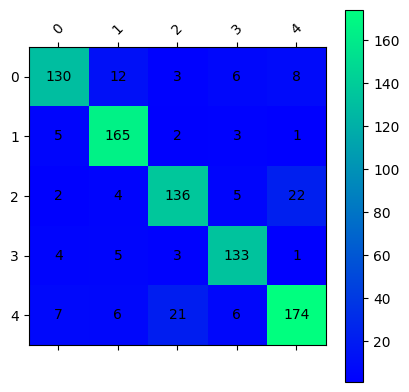

In [17]:
model_svm_l.fit(x_train,y_train)
y_pred = model_svm_l.predict(x_test)

df_confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(df_confusion)

In [18]:
rec_score = recall_score(y_test, y_pred, average='weighted')
rec_score

0.8541666666666666

In [19]:
print(classification_report(y_test, y_pred, target_names=dirs.keys()))

              precision    recall  f1-score   support

       daisy       0.88      0.82      0.85       159
   dandelion       0.86      0.94      0.90       176
        rose       0.82      0.80      0.81       169
   sunflower       0.87      0.91      0.89       146
       tulip       0.84      0.81      0.83       214

    accuracy                           0.85       864
   macro avg       0.86      0.86      0.86       864
weighted avg       0.85      0.85      0.85       864



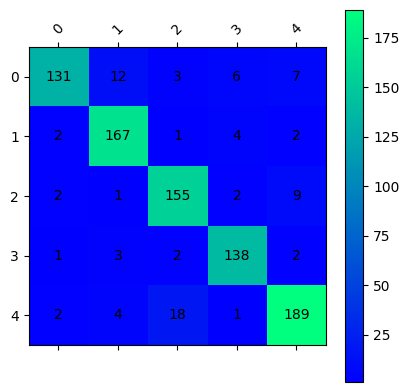

In [33]:
model_svm_r.fit(x_train,y_train)
y_pred = model_svm_r.predict(x_test)

df_confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(df_confusion)

In [21]:
rec_score = recall_score(y_test, y_pred, average='weighted')
rec_score

0.9027777777777778

In [22]:
print(classification_report(y_test, y_pred, target_names=dirs.keys()))

              precision    recall  f1-score   support

       daisy       0.95      0.82      0.88       159
   dandelion       0.89      0.95      0.92       176
        rose       0.87      0.92      0.89       169
   sunflower       0.91      0.95      0.93       146
       tulip       0.90      0.88      0.89       214

    accuracy                           0.90       864
   macro avg       0.91      0.90      0.90       864
weighted avg       0.90      0.90      0.90       864



D:\Project Fluids\venv\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


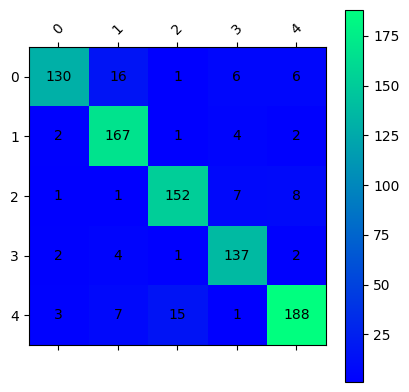

In [23]:
model_svm_p.fit(x_train,y_train)
y_pred = model_svm_p.predict(x_test)

df_confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(df_confusion) 

In [24]:
rec_score = recall_score(y_test, y_pred, average='weighted')
rec_score

0.8958333333333334

In [25]:
print(classification_report(y_test, y_pred, target_names=dirs.keys()))

              precision    recall  f1-score   support

       daisy       0.94      0.82      0.88       159
   dandelion       0.86      0.95      0.90       176
        rose       0.89      0.90      0.90       169
   sunflower       0.88      0.94      0.91       146
       tulip       0.91      0.88      0.90       214

    accuracy                           0.90       864
   macro avg       0.90      0.90      0.90       864
weighted avg       0.90      0.90      0.90       864



Лучше всего отработали модели: SVM с ядрами poly и rbf